
文件目录
- data
    - train
        - imgae
        - mask
    - test
        - image

In [73]:
# 加载一些基础的库
import os
import cv2
import torch
import zipfile
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm # 一个实现进度条的库
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [74]:
# 路径配置
train_path = './data/train/'
test_path = './data/test/'
img_save_path = './data/result/baseline/'
output_path = './data/result/baseline-infer.zip'

# 模型保存的路径
model_path = './models/baseline/'

In [75]:
transform = transforms.Compose({
    # 转化为Tensor
    transforms.ToTensor()
})

# 首先继承Dataset写一个对于数据进行读入和处理的方式
class MyDataset(Dataset):
    def __init__(self, path):
        self.mode = 'train' if 'mask' in os.listdir(path) else 'test' # 表示训练模式
        self.path = path # 图片路径
        dirlist = os.listdir(path + 'image/') # 图片的名称
        self.name = [n for n in dirlist if n[-3:] == 'png'] # 只读取图片
        
    def __len__(self):
        return len(self.name)
    
    def __getitem__(self, index): # 获取数据的处理方式
        name = self.name[index]
        # 读取原始图片和标签
        if self.mode == 'train': # 训练模式
            ori_img = cv2.imread(self.path + 'image/'+ name) # 原始图片
            lb_img = cv2.imread(self.path + 'mask/' + name) # 标签图片
            ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB) # 转为RGB三通道图
            lb_img = cv2.cvtColor(lb_img, cv2.COLOR_BGR2GRAY) # 掩膜转为灰度图
            return transform(ori_img), transform(lb_img)
        
        if self.mode == 'test': # 测试模式
            ori_img = cv2.imread(self.path + 'image/' + name) # 原始图片
            ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB) # 转为RGB三通道图
            return transform(ori_img)

#加载数据集
traindata = MyDataset(train_path)

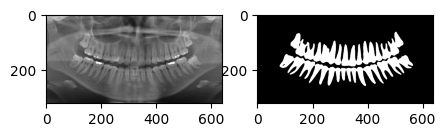

原始图片张量的形状: torch.Size([3, 320, 640])
标签图片张量的形状: torch.Size([1, 320, 640])


In [76]:
#查看图片读取效果
o_img,l_img = traindata[np.random.randint(0,1600)]
plt.figure(figsize=(5, 12))
plt.subplot(1, 2, 1)
plt.imshow(o_img.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(l_img.permute(1, 2, 0), cmap='Greys_r')
plt.show()
print("原始图片张量的形状:", o_img.shape)
print("标签图片张量的形状:", l_img.shape) # ([1, 320, 640]) 其中 1 表示分类类别，我们为2分类任务,类别表示为01

In [77]:
# 配置模型超参数
# 推荐使用gpu进行训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 学习率
lr = 3e-3
# 学习率衰减
weight_decay = 1e-3
# 批大小
bs = 8
# 训练轮次
epochs = 10

In [78]:
'''
加载经典用于医学图像分割的UNet
encoder_name为模型的backbone
encoder_weigths可选imagenet或者None代表是否加载预训练参数
in_channel为输入图像的通道数
classes为分类数目
'''
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights='imagenet',
    in_channels=3,
    classes=1,
)
# 打印模型信息
print(model)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [79]:
# 训练前准备
# 加载模型到gpu或cpu
model.to(device)

# 加载优化器,使用Adam,主要是炼的快(๑ت๑)
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
# 使用traindata创建dataloader对象
trainloader = DataLoader(traindata, batch_size=bs, shuffle=True, num_workers=0)
# 使用Binary CrossEntropy作为损失函数，主要处理二分类问题
# BCEloss = nn.BCELoss()
# 根据赛题评测选用dice_loss，这个是开源代码
def dice_loss(logits, target):
    smooth = 1.
    prob  = torch.sigmoid(logits)
    batch = prob.size(0)
    prob   = prob.view(batch, 1, -1)
    target = target.view(batch, 1, -1)
    intersection = torch.sum(prob*target, dim=2)
    denominator  = torch.sum(prob, dim=2) + torch.sum(target, dim=2)
    dice = (2 * intersection + smooth) / (denominator + smooth)
    dice = torch.mean(dice)
    return 1. - dice

In [42]:
#开始炼丹 没有做验证集，各位可以以自己需要去添加
loss_last = 99999
best_model_name = 'x'
#记录loss变化
for epoch in range(1, epochs + 1):
    losses = []
    for step, (inputs, labels) in tqdm(
        enumerate(trainloader),
        desc=f"Epoch {epoch}/{epochs}",
        ascii=True,
        total=len(trainloader)
    ):
        #原始图片和标签
        inputs, labels = inputs.to(device), labels.to(device)
        out = model(inputs)
        loss = dice_loss(out, labels)
        # 后向
        optim.zero_grad()
        #梯度反向传播
        loss.backward()
        optim.step()
        losses.append(loss.detach().cpu().item())
    #损失小于上一轮则添加
    loss_mean = np.mean(losses)
    if loss_mean < loss_last:
        loss_last = loss_mean
        torch.save(model.state_dict(), model_path + 'model_epoch{}_loss{}.pth'.format(epoch, loss_mean))
        best_model_name = model_path + 'model_epoch{}_loss{}.pth'.format(epoch, loss_mean)
    print(f"\nEpoch: {epoch}/{epochs}, DiceLoss:{loss_mean}")

Epoch 1/10: 100%|##########| 200/200 [00:49<00:00,  4.02it/s]



Epoch: 1/10, DiceLoss:0.17359341591596603


Epoch 2/10: 100%|##########| 200/200 [00:48<00:00,  4.12it/s]



Epoch: 2/10, DiceLoss:0.13149302154779435


Epoch 3/10: 100%|##########| 200/200 [00:47<00:00,  4.19it/s]



Epoch: 3/10, DiceLoss:0.1358500349521637


Epoch 4/10: 100%|##########| 200/200 [00:48<00:00,  4.10it/s]



Epoch: 4/10, DiceLoss:0.12419615238904953


Epoch 5/10: 100%|##########| 200/200 [00:47<00:00,  4.22it/s]



Epoch: 5/10, DiceLoss:0.13097566723823548


Epoch 6/10: 100%|##########| 200/200 [00:49<00:00,  4.06it/s]



Epoch: 6/10, DiceLoss:0.1255709135532379


Epoch 7/10: 100%|##########| 200/200 [00:47<00:00,  4.23it/s]



Epoch: 7/10, DiceLoss:0.11760280013084412


Epoch 8/10: 100%|##########| 200/200 [00:48<00:00,  4.09it/s]



Epoch: 8/10, DiceLoss:0.13772966235876083


Epoch 9/10: 100%|##########| 200/200 [00:46<00:00,  4.29it/s]



Epoch: 9/10, DiceLoss:0.12184303730726243


Epoch 10/10: 100%|##########| 200/200 [00:49<00:00,  4.06it/s]


Epoch: 10/10, DiceLoss:0.1165357032418251


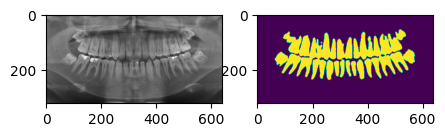

In [80]:
#加载最优模型
model.load_state_dict(torch.load(best_model_name))
#加载测试集
testdata = MyDataset(test_path)
#测试模型的预测效果
x = np.random.randint(0, 400)
inputs = testdata[x].to(device)

with torch.no_grad():
    # 模型预测
    t = model(inputs.view(1, 3, 320, 640))

plt.figure(figsize=(5, 12))
plt.subplot(1, 2, 1)
plt.imshow(testdata[x].permute(1, 2, 0))
#对预测的图片采取一定的阈值进行分类
threshold = 0.5
t = torch.where(t >= threshold, torch.tensor(255, dtype=torch.float).to(device), t)
t = torch.where(t < threshold, torch.tensor(0, dtype=torch.float).to(device), t)
t = t.cpu().view(1, 320, 640)
plt.subplot(1, 2, 2)
plt.imshow(t.permute(1, 2, 0))
plt.show()

In [81]:
for i, inputs in tqdm(enumerate(testdata)):
    # 原始图片和标签
    inputs = inputs.reshape(1, 3, 320, 640).to(device)
    # 输出生成的图像
    out = model(inputs.view(1, 3, 320, 640)) # 模型预测
    # 对输出的图像进行后处理
    threshold = 0.5
    out = torch.where(out >= threshold, torch.tensor(255, dtype=torch.float).to(device), out)
    out = torch.where(out < threshold, torch.tensor(0, dtype=torch.float).to(device), out)
    # 保存图像
    out= out.detach().cpu().numpy().reshape(1,320,640)
    # 注意保存为1位图提交
    img = Image.fromarray(out[0].astype(np.uint8))
    img = img.convert('1')
    img.save(img_save_path + testdata.name[i])

400it [00:09, 40.86it/s]


In [85]:
import os
from PIL import Image
import numpy as np
import torch
 # 请根据你的实际情况修改这一行
from metric import hausdorff_distance_2d,dice_coefficient,intersection_over_union
# 获取图片文件列表
pred_dir = 'D:/Download/sts-2d-master/sts-2d-master/data/result/baseline/'
mask_dir = 'D:/Download/sts-2d-master/sts-2d-master/data/val/mask/'
pred_files = sorted(os.listdir(pred_dir))
mask_files = sorted(os.listdir(mask_dir))

# 确保预测图片和掩码图片的数量相同
assert len(pred_files) == len(mask_files)
dices=[]
iou_scores=[]
hausdorff_scores = []
# 对每一对预测图片和掩码图片进行处理
for pred_file, mask_file in zip(pred_files, mask_files):
    # 读取图片

# 读取图片并转换为numpy数组
    pred = np.array(Image.open(os.path.join(pred_dir, pred_file)))
    mask = np.array(Image.open(os.path.join(mask_dir, mask_file)))

    # 将numpy数组转换为张量并添加一个新的维度来表示批量大小
    pred = torch.from_numpy(pred).unsqueeze(0)
    mask = torch.from_numpy(mask).unsqueeze(0)

    # 计算度量
    dice = dice_coefficient(pred, mask)
    iou_score = intersection_over_union(pred, mask)
    hausdorff = hausdorff_distance_2d(pred, mask)

    # dices.append(dice.cpu().numpy())
    # iou_scores.append(iou_score.cpu().numpy())
    # hausdorff_scores.append(hausdorff.cpu().numpy())
    # dice_score = np.mean(dices)
    # iou_score = np.mean(iou_scores)
    # hausdorff_score = np.mean(hausdorff_scores)
    score = 0.4 * dice + 0.3 * iou_score + 0.3 * (1 - hausdorff)
    # 打印结果
    print(f'For {pred_file} and {mask_file}: Dice = {dice}, IoU = {iou_score}, Hausdorff = {hausdorff},score = {score}')

For A-1.png and A-1.png: Dice = tensor([1.9397]), IoU = tensor([0.9736]), Hausdorff = tensor([0.9962]),score = tensor([1.0691])
For A-10.png and A-10.png: Dice = tensor([1.9733]), IoU = tensor([0.9906]), Hausdorff = tensor([0.9961]),score = tensor([1.0877])
For A-1000.png and A-1000.png: Dice = tensor([1.8482]), IoU = tensor([0.9275]), Hausdorff = tensor([0.9961]),score = tensor([1.0187])
For A-1011.png and A-1011.png: Dice = tensor([1.8098]), IoU = tensor([0.9082]), Hausdorff = tensor([0.9965]),score = tensor([0.9974])
For A-102.png and A-102.png: Dice = tensor([1.8165]), IoU = tensor([0.9116]), Hausdorff = tensor([0.9961]),score = tensor([1.0012])
For A-1021.png and A-1021.png: Dice = tensor([1.7988]), IoU = tensor([0.9026]), Hausdorff = tensor([0.9964]),score = tensor([0.9914])
For A-1024.png and A-1024.png: Dice = tensor([1.7540]), IoU = tensor([0.8800]), Hausdorff = tensor([0.9962]),score = tensor([0.9667])
For A-1028.png and A-1028.png: Dice = tensor([1.7945]), IoU = tensor([0.90

score:0.67908
dice:0.8577
iou:0.8390
hausdorff_distance:0.719
